# Deconvolution Benchmark: Julia

---
## Setup

In [1]:
using DeconvOptim, TestImages, Colors, ImageIO, Noise, ImageShow, Images, Plots, BenchmarkTools, FFTW

In [2]:
FFTW.set_num_threads(6)

---
## Test Image

Una vez importados los paquetes lo que hemos hecho ha sido coger una imagen de prueba, añadirla borrosidad y ruido y hacer la deconvolución en 2D sin regularizar.
Usaremos la misma PSF para el código en python y el mismo número de iteraciones.


In [3]:
# Cargar la imagen de prueba
img = load("ImagenPrueba.jpg")
img = Float32.(img)

# Generar la PSF (Point Spread Function)
psf = Float32.(generate_psf(size(img), 30))

# Crear una versión borrosa y ruidosa de la imagen
img_b = conv(img, psf)  # Imagen borrosa
img_n = poisson(img_b, 300)  # Imagen borrosa y ruidosa

# Guardar la imagen borrosa y ruidosa
# save("blurrednoisy_img.jpg", img_b)

# Deconvolución 2D sin regularizador
res_no_reg, o = deconvolution(img_n, psf, regularizer=nothing, iterations=30)

# Medir el tiempo de ejecución de la deconvolución

b = @benchmark  deconvolution(img_n, psf, regularizer=nothing, iterations=30) samples=15 evals=1

BenchmarkTools.Trial: 11 samples with 1 evaluation.
 Range (min … max):  281.218 ms … 783.442 ms  ┊ GC (min … max):  1.73% … 63.23%
 Time  (median):     357.158 ms               ┊ GC (median):    16.43%
 Time  (mean ± σ):   428.902 ms ± 155.125 ms  ┊ GC (mean ± σ):  33.03% ± 21.50%

  █▁   ▁▁  ▁                █ ▁  ▁                            ▁  
  ██▁▁▁██▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁█▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  281 ms           Histogram: frequency by time          783 ms <

 Memory estimate: 172.58 MiB, allocs estimate: 5827.

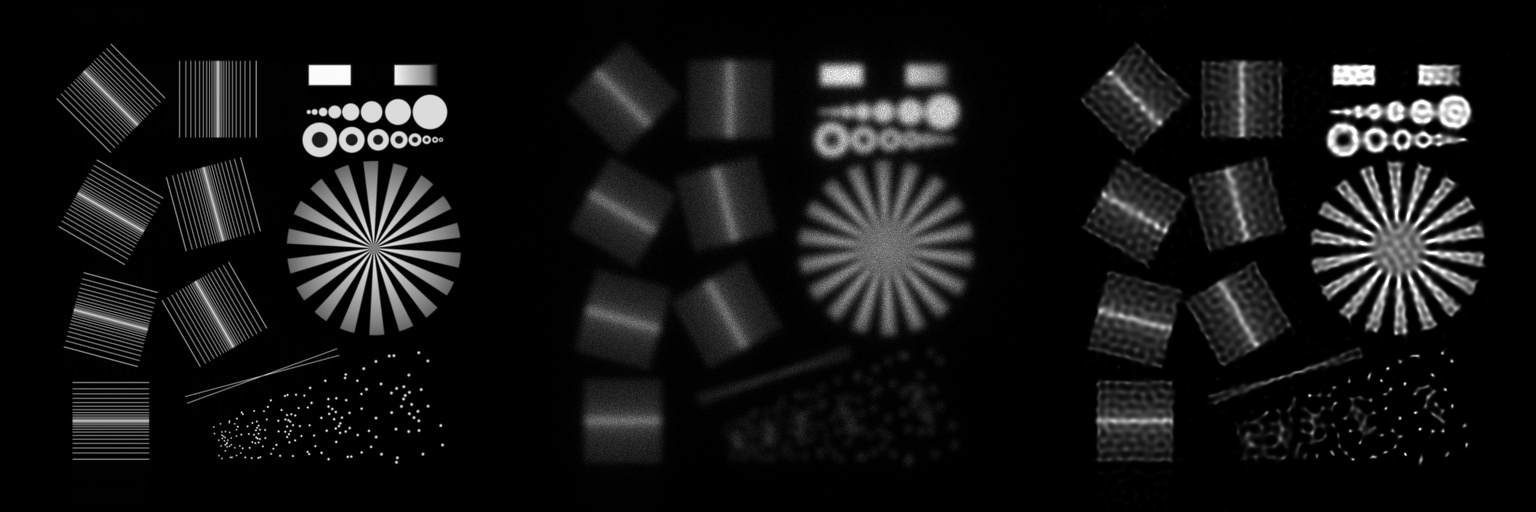

In [4]:
# Mostrar los resultados finales junto a la versión original y la versión borrosa
Gray.([img img_n res_no_reg])

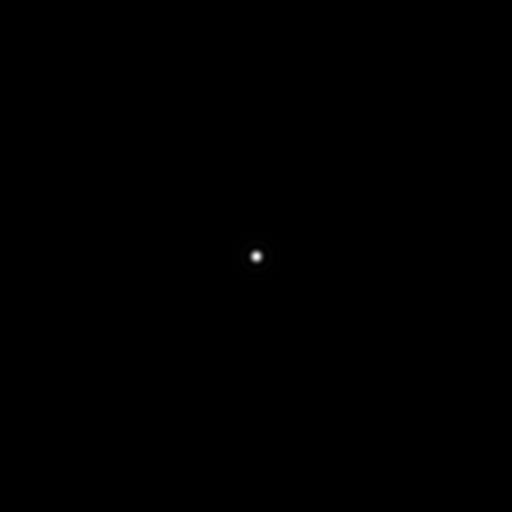

In [5]:
# Suponemos que psf ya está definida
# Normaliza los valores de la PSF al rango [0, 1]
psf_min = minimum(psf)
psf_max = maximum(psf)
psf_normalized = (psf .- psf_min) ./ (psf_max - psf_min)
psf_gray = Gray.(psf_normalized)  # Convertir a escala de grises

# Centrar la PSF utilizando ifftshift
centered_psf = ifftshift(psf_normalized)
centered_psf_gray = Gray.(centered_psf)  # Convertir a escala de grises

# Guardar la PSF normalizada como una imagen JPEG
# save("psf.jpg", centered_psf_gray)

# Mostrar la PSF centrada
display(centered_psf_gray)


Ahora vamos a usar la función richardson_lucy_iterative del módulo deconvoptim.jl sin regularización.

In [6]:
# Deconvolución iterativa de Richardson-Lucy sin regularizador
restored_img = richardson_lucy_iterative(img_n, psf; regularizer=nothing, iterations=30);

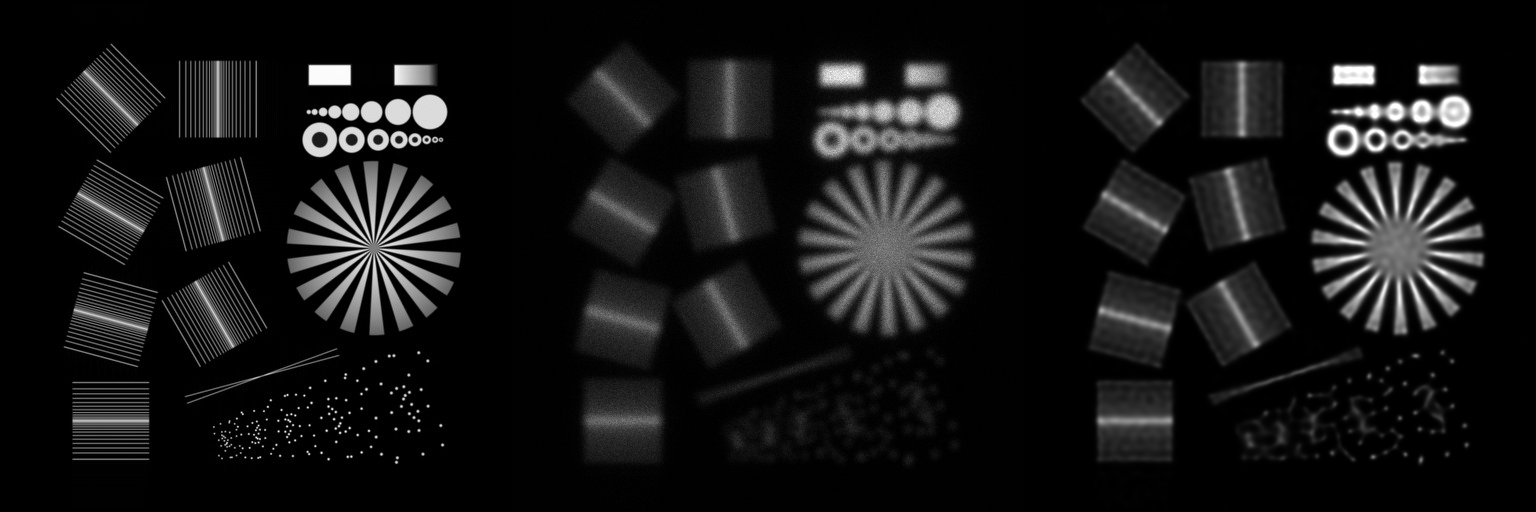

In [7]:
Gray.([img img_n restored_img])

In [8]:
c = @benchmark richardson_lucy_iterative(img_n, psf; regularizer=nothing, iterations=30) samples=100 evals=1 seconds=60

BenchmarkTools.Trial: 100 samples with 1 evaluation.
 Range (min … max):  29.075 ms … 49.152 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     32.002 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   33.393 ms ±  3.793 ms  ┊ GC (mean ± σ):  1.59% ± 3.67%

     ▄▃█▆▄█▆▃ ▃                                                
  ▄▆▆████████▄█▇▄▆▆▁▄▆▇▄▇▄▆▆▆▁▄▇▁▁▄▄▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▄▁▄▄▁▁▁▁▁▄ ▄
  29.1 ms         Histogram: frequency by time        46.6 ms <

 Memory estimate: 7.01 MiB, allocs estimate: 33.

Veremos ahora ejemplos con TV regularization en Julia

In [9]:
# Deconvolución iterativa de Richardson-Lucy con regularizador
optim_res = richardson_lucy_iterative(img_n, psf, λ=0.05, regularizer=TV(), iterations=30)
d1 = @benchmark richardson_lucy_iterative(img_n, psf, λ=0.05, regularizer=TV(), iterations=30) samples=100 evals=1 seconds=60

BenchmarkTools.Trial: 96 samples with 1 evaluation.
 Range (min … max):  578.506 ms … 911.940 ms  ┊ GC (min … max): 2.36% … 2.42%
 Time  (median):     604.450 ms               ┊ GC (median):    2.36%
 Time  (mean ± σ):   618.602 ms ±  43.491 ms  ┊ GC (mean ± σ):  2.53% ± 0.83%

     ██  ▆▃                                                      
  ▅█▇███▇███▇▅▅▄▄▇█▅▄█▅▁▁▅▇▅▅▄▄▅▁▁▁▁▅▁▁▁▁▁▄▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▄ ▁
  579 ms           Histogram: frequency by time          753 ms <

 Memory estimate: 76.77 MiB, allocs estimate: 640300.

In [10]:
# Deconvolución iterativa de Richardson-Lucy con regularizador (optimizada)
tv = TV()

#859 (generic function with 1 method)

In [11]:
d2 = @benchmark richardson_lucy_iterative(img_n, psf, λ=0.05, regularizer=tv, iterations=30) samples=100 evals=1 seconds=60

BenchmarkTools.Trial: 100 samples with 1 evaluation.
 Range (min … max):  60.040 ms … 94.087 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     71.770 ms              ┊ GC (median):    5.12%
 Time  (mean ± σ):   72.394 ms ±  6.197 ms  ┊ GC (mean ± σ):  3.66% ± 2.97%

              ▄   ▄  █ ▂█      █ ▆    ▂                        
  █▁▄▁▁▄▆▁▆█▄▆█▆▁▄██▆█████▆▆▄▆▄███▄█▄▄█▁▄▆▄▁▁▁▄▄▁▁▁▁▁▁▄▁▁▁▁▁▄ ▄
  60 ms           Histogram: frequency by time        90.9 ms <

 Memory estimate: 38.04 MiB, allocs estimate: 1057.

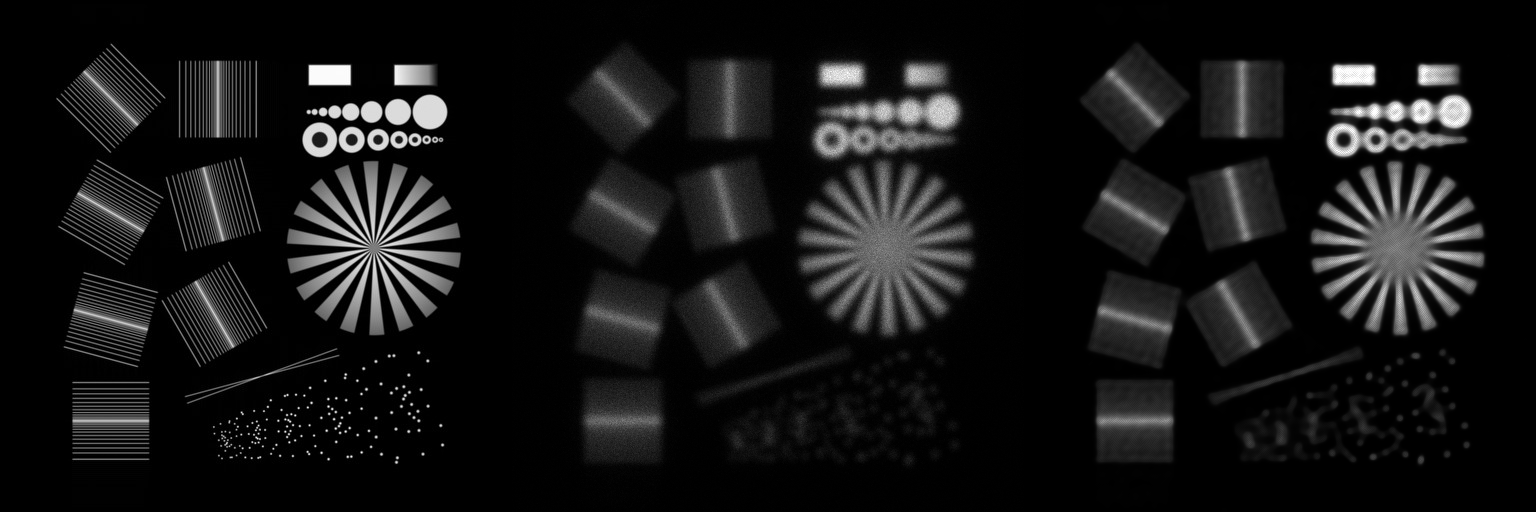

In [12]:
Gray.([img img_n optim_res])

---
## Cell
Test usando solo el plano central del `cells3D` dataset

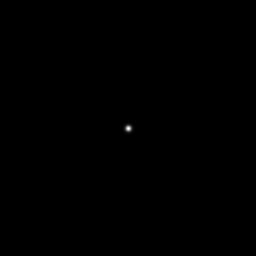

In [14]:
img = load("cells2d_convolved.tif")
img = Float32.(img)

psf = load("cells2d_psf.tif")
psf = Float32.(psf);

Gray.(psf/maximum(psf))

In [15]:
ipsf = ifftshift(psf);

In [16]:
deconvolved = richardson_lucy_iterative(img, ipsf; regularizer=nothing, iterations=30);

In [17]:
 c = @benchmark richardson_lucy_iterative(img, ipsf; regularizer=nothing, iterations=30) samples=100 evals=1 seconds=60

BenchmarkTools.Trial: 100 samples with 1 evaluation.
 Range (min … max):  10.953 ms … 23.919 ms  ┊ GC (min … max): 0.00% … 35.74%
 Time  (median):     12.343 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   12.913 ms ±  2.012 ms  ┊ GC (mean ± σ):  1.29% ±  4.94%

      ▅▇█▃▆▂                                                   
  ▇▇▅▇██████▇▁▅▁▁▁▁▅▅▁▅▁▁▁▅▅▅▁▁▅▁▅▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅ ▅
  11 ms        Histogram: log(frequency) by time      23.5 ms <

 Memory estimate: 1.76 MiB, allocs estimate: 33.

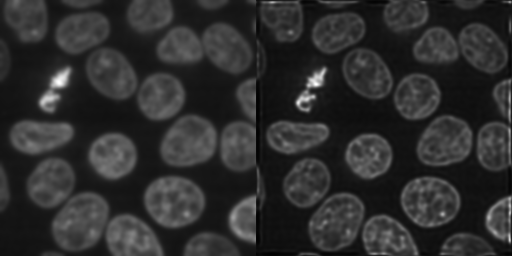

In [18]:
Gray.([img/maximum(img) deconvolved/maximum(deconvolved)])